In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

import os
import datetime
import psycopg2
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.cm as cm
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_venn import venn3
from itertools import combinations
import matplotlib.ticker as mticker
from dateutil.relativedelta import relativedelta
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT"))
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DATA_FOLDER = os.getenv("DATA_FOLDER")

In [3]:
bigbrotr = psycopg2.connect(
    host=DB_HOST,
    port=DB_PORT,
    user=DB_USER,
    password=DB_PASSWORD,
    dbname=DB_NAME
)

In [4]:
# Generate events.csv if it does not exist
if "events.csv" not in os.listdir(DATA_FOLDER):
    with bigbrotr.cursor() as cur:
        with open(os.path.join(DATA_FOLDER, 'events.csv'), 'w') as f:
            cur.copy_expert("COPY (SELECT id, pubkey, created_at, kind FROM events) TO STDOUT WITH CSV HEADER", f)
# Load events data
events = pl.read_csv(os.path.join(DATA_FOLDER, 'events.csv'), columns=["pubkey", "created_at", "kind"])
events = events.with_columns(
    (pl.col("created_at") * 1000).cast(pl.Datetime("ms")).alias("created_at")
)
events = events.with_columns([
    pl.col("created_at").dt.truncate("1d").alias("day"),
    pl.col("created_at").dt.truncate("1mo").alias("month")
])

In [5]:
# Count total events and unique pubkeys
total_events = events.shape[0]
total_pubkeys = events['pubkey'].n_unique()
print(f"Number of total events: {total_events}")
print(f"Number of unique pubkeys: {total_pubkeys}")

Number of total events: 172664903
Number of unique pubkeys: 19681031


In [6]:
# Count events grouped by their 'kind' value
kind_counts = (
    events.group_by("kind")             # Group the DataFrame by the 'kind' column
    .agg(pl.count())                    # Aggregate each group by counting the number of rows (events)
    .rename({"count": "count"})        # Rename the resulting count column to 'count' (optional here, since default is 'count')
    .sort("count", descending=True)   # Sort the groups by count in descending order (most frequent kinds first)
    .with_columns(                     # Add a new column calculating the percentage of each kind's count relative to total
        (pl.col("count") / pl.col("count").sum() * 100).alias("perc")
    )
)

print("Top 20 event kinds by count:")
kind_counts.to_pandas().head(20)

Top 20 event kinds by count:


,kind,count,perc
0,1,67266176,38.957643
1,7,32614859,18.889107
2,4,9715277,5.626666
3,0,8163256,4.727803
4,3,7837013,4.538857
5,6,7591314,4.396559
6,5,5382124,3.117092
7,9735,4858240,2.813681
8,1000,4508139,2.610918
9,1059,3751739,2.172844


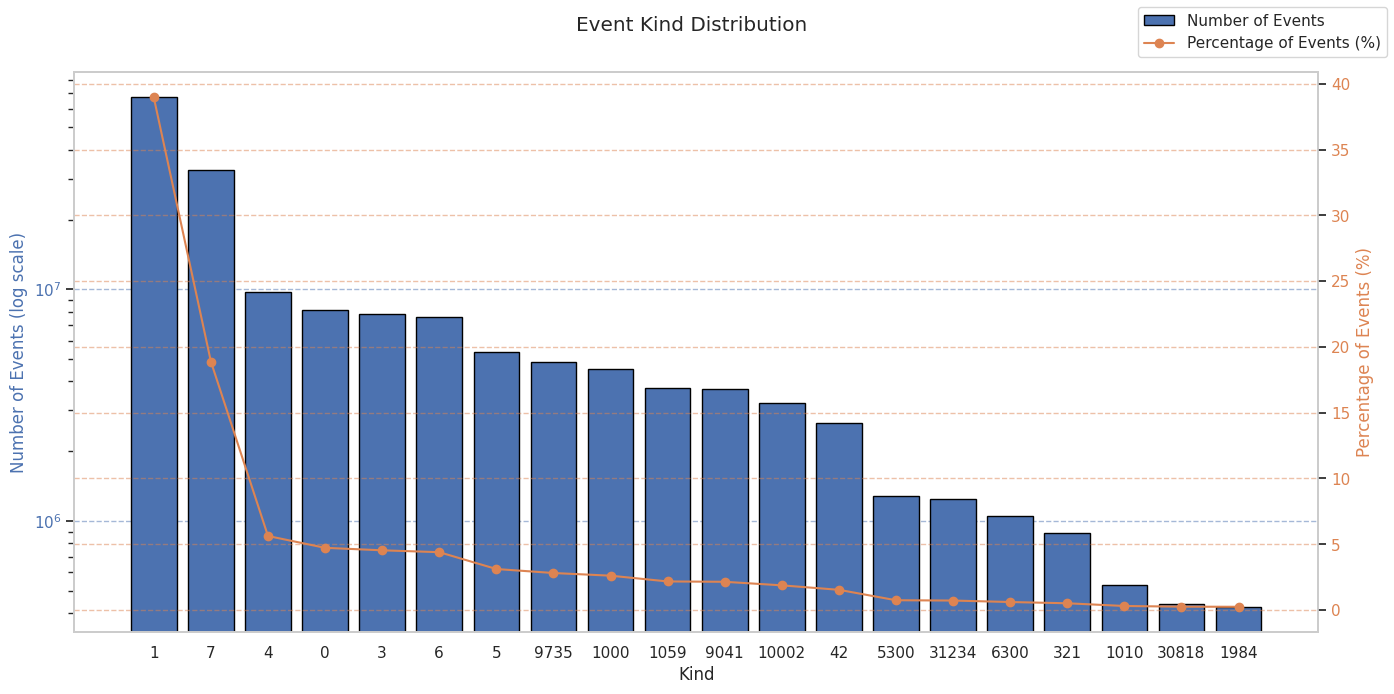

In [7]:
# Convert the top 20 rows of kind_counts (Polars DF) to Pandas for plotting
df_plot = kind_counts.head(20).to_pandas()

# Convert 'kind' to string for categorical x-axis labels
kind_labels = df_plot['kind'].astype(str)

# Setup figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Colors for bar and line
color_count = '#4C72B0'  # soft blue
color_perc = '#DD8452'   # orange

# Primary axis grid only on y-axis (vertical grid lines off)
ax1.grid(axis='y', linestyle='--', color=color_count, alpha=0.5, zorder=0)
ax1.grid(axis='x', visible=False)

# Bar plot for counts with log scale on y-axis
ax1.bar(kind_labels, df_plot['count'], color=color_count, edgecolor='black', label='Number of Events', zorder=1)
ax1.set_xlabel('Kind')
ax1.set_ylabel('Number of Events (log scale)', color=color_count)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color_count)

# Secondary axis for percentage line plot
ax2 = ax1.twinx()
ax2.patch.set_visible(False)  # Transparent background

# Line plot for percentages
ax2.plot(kind_labels, df_plot['perc'], color=color_perc, marker='o', label='Percentage of Events (%)', zorder=3)
ax2.set_ylabel('Percentage of Events (%)', color=color_perc)
ax2.tick_params(axis='y', labelcolor=color_perc)

# Grid for secondary axis on y only
ax2.grid(axis='y', linestyle='--', color=color_perc, alpha=0.5, zorder=0)

# Title and combined legend from both axes
fig.suptitle('Event Kind Distribution')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
fig.legend(lines_labels, labels)

# Layout and spacing adjustments
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [8]:
# Select unique pairs of ('kind', 'pubkey') to get unique users per event kind
kind_share = events.unique(subset=["kind", "pubkey"])

# Count how many unique users ('pubkey') exist for each 'kind'
kind_share = (
    kind_share.group_by("kind")
    .agg(pl.count("pubkey").alias("count"))
    .sort("count", descending=True)
)

# Calculate the percentage share of each kind relative to total unique users
kind_share = kind_share.with_columns(
    (pl.col("count") / pl.col("count").sum() * 100).alias("perc")
)

print("Top 20 event kinds by unique users:")
kind_share.to_pandas().head(20)

Top 20 event kinds by unique users:


,kind,count,perc
0,0,7370423,27.358678
1,3,7305744,27.118593
2,1059,3748915,13.915804
3,1,3425960,12.717009
4,10002,1940087,7.201516
5,9041,1608272,5.969833
6,4,449046,1.666839
7,7,217747,0.808267
8,5,118556,0.440075
9,6,100252,0.372131


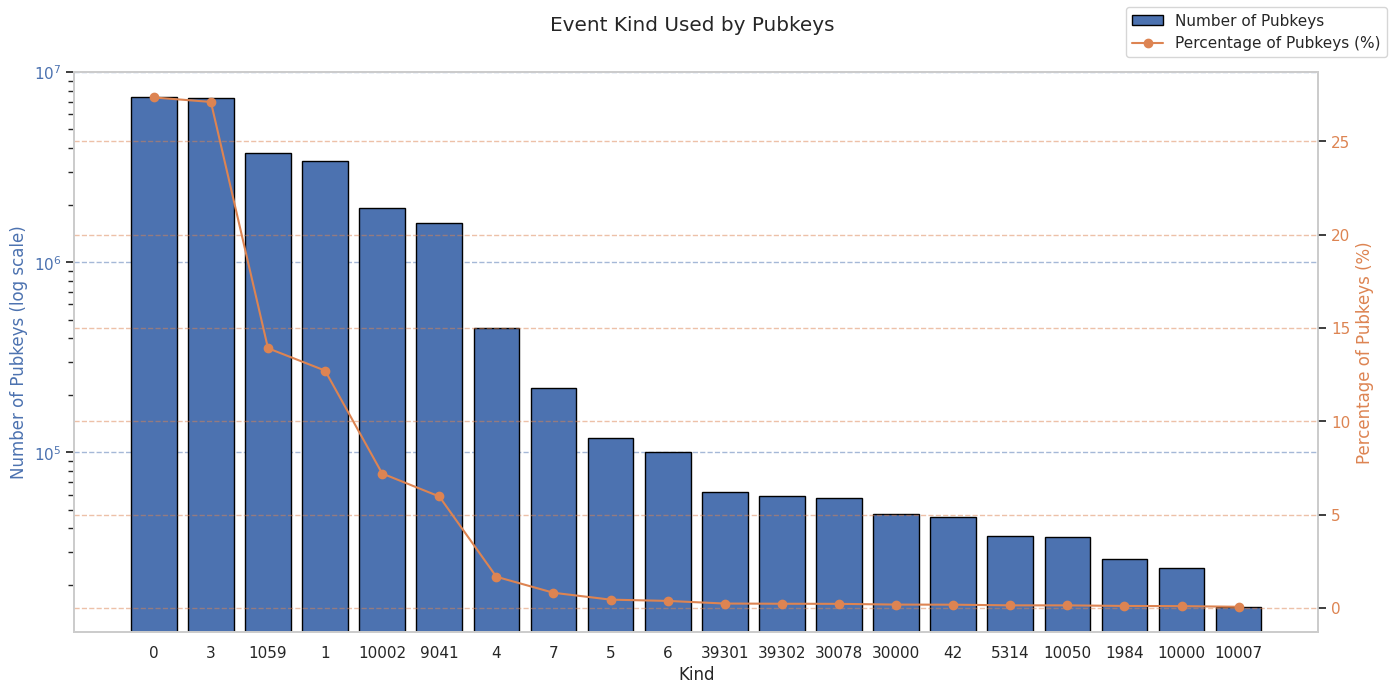

In [9]:
# Convert top 20 rows of kind_share (Polars DataFrame) to Pandas for plotting
df_plot = kind_share.head(20).to_pandas()

# Convert 'kind' to string for categorical x-axis labels
kind_labels = df_plot['kind'].astype(str)

# Set up the figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Colors for bars and line
color_count = '#4C72B0'  # soft blue
color_perc = '#DD8452'   # orange

# Primary axis grid on y only, no x grid
ax1.grid(axis='y', linestyle='--', color=color_count, alpha=0.5, zorder=0)
ax1.grid(axis='x', visible=False)

# Bar chart for number of unique pubkeys, y-axis log scale
ax1.bar(kind_labels, df_plot['count'], color=color_count, edgecolor='black',
        label='Number of Pubkeys', zorder=1)
ax1.set_xlabel('Kind')
ax1.set_ylabel('Number of Pubkeys (log scale)', color=color_count)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color_count)

# Secondary axis for percentage line plot
ax2 = ax1.twinx()
ax2.patch.set_visible(False)  # Transparent background

# Line plot for percentage of pubkeys
ax2.plot(kind_labels, df_plot['perc'], color=color_perc, marker='o',
         label='Percentage of Pubkeys (%)', zorder=3)
ax2.set_ylabel('Percentage of Pubkeys (%)', color=color_perc)
ax2.tick_params(axis='y', labelcolor=color_perc)

# Grid on secondary y-axis only
ax2.grid(axis='y', linestyle='--', color=color_perc, alpha=0.5, zorder=0)

# Title and combined legend
fig.suptitle('Event Kind Used by Pubkeys')

# Combine legends from both axes
lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
fig.legend(lines_labels, labels)

# Final layout adjustment
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [10]:
# Merge 'kind_share' and 'kind_counts' on 'kind' column
kind_stats = kind_share.join(
    kind_counts,
    on="kind",
    how="inner",
    suffix="_pubkey"
).rename({
    col: col + "_event" for col in kind_counts.columns if col != "kind"
})

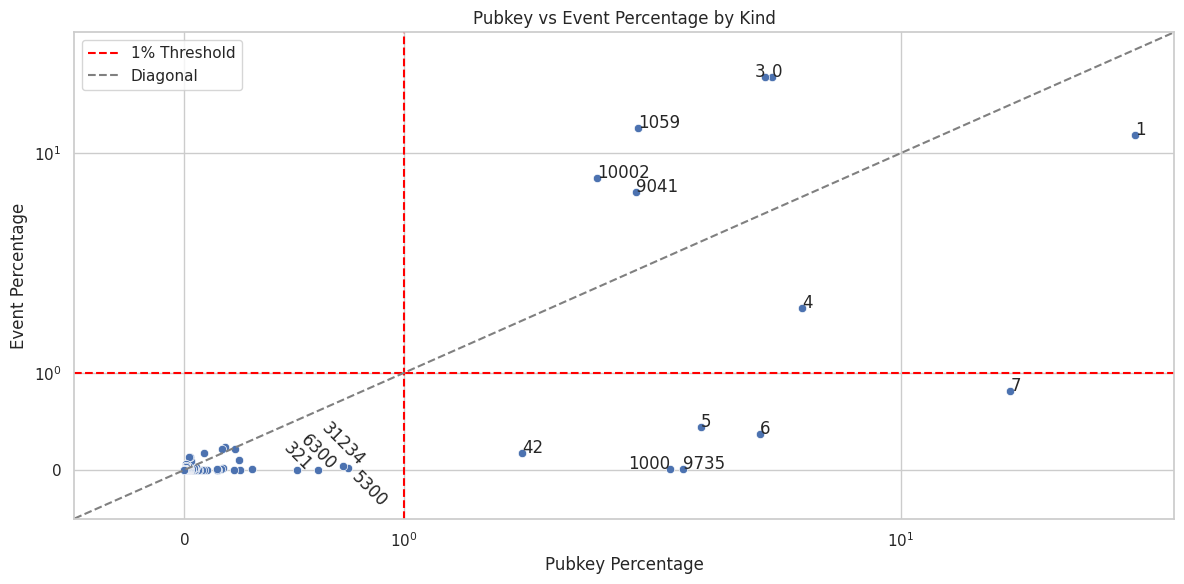

In [11]:
# Convert Polars DataFrame to Pandas for plotting
kind_stats_pd = kind_stats.to_pandas()

plt.figure()

# Scatter plot: pubkey percentage vs event percentage by kind (axes swapped)
sns.scatterplot(
    data=kind_stats_pd,
    x='perc_pubkey',  # x is now pubkey percentage
    y='perc_event',   # y is now event percentage
)

plt.xlabel('Pubkey Percentage')   # swapped labels
plt.ylabel('Event Percentage')
plt.title('Pubkey vs Event Percentage by Kind')

# Use symmetric log scale for both axes
plt.xscale('symlog')
plt.yscale('symlog')

# Determine min and max values from both percentages for consistent axis limits
min_val = min(kind_stats_pd['perc_event'].min(), kind_stats_pd['perc_pubkey'].min())
max_val = max(kind_stats_pd['perc_event'].max(), kind_stats_pd['perc_pubkey'].max())

plt.xlim(min_val - 0.5, max_val + 10)
plt.ylim(min_val - 0.5, max_val + 10)

# Add labels for points where either percentage >= 0.5% (swap x and y here too)
for i, row in kind_stats_pd.iterrows():
    if row['perc_event'] >= 0.5 or row['perc_pubkey'] >= 0.5:
        kind_value = int(row['kind'])  # cast to int here
        x_val = row['perc_pubkey']
        y_val = row['perc_event']

        if kind_value in [321, 6300, 31234]:
            plt.text(x_val, y_val, kind_value, ha='center', va='baseline', rotation=-45)
        elif kind_value == 5300:
            plt.text(x_val, y_val, kind_value, ha='left', va='top', rotation=-45)
        elif kind_value not in [3, 1000]:
            plt.text(x_val, y_val, kind_value, ha='left', va='baseline')
        else:  # kind_value in [3, 1000]
            plt.text(x_val, y_val, kind_value, ha='right', va='baseline')

# Add threshold lines at 1% (horizontal and vertical swapped)
plt.axvline(x=1, linestyle='--', color='red', label='1% Threshold')
plt.axhline(y=1, linestyle='--', color='red')

# Add diagonal line (x=y)
plt.plot([min_val - 0.5, max_val + 10], [min_val - 0.5, max_val + 10],
         linestyle='--', color='gray', label='Diagonal')

plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# Load additional metadata about kinds from CSV
kinds_info = pd.read_csv(os.path.join(DATA_FOLDER, 'kinds_info.csv'))

# Filter kinds where either event or pubkey percentage >= 0.5%
relevant_kinds = kind_stats_pd[
    (kind_stats_pd['perc_event'] >= 0.5) | (kind_stats_pd['perc_pubkey'] >= 0.5)
][['kind']]

# Merge filtered kinds with metadata
relevant_kinds = relevant_kinds.merge(kinds_info, on='kind', how='left')

# Show resulting DataFrame
display(relevant_kinds)

,kind,title,linked_code,file_name,status
0,1,Short Text Note,10,10.md,NaN
1,7,Reaction,25,25.md,NaN
2,4,Encrypted Direct Messages,04,04.md,NaN
3,0,User Metadata,01,01.md,NaN
4,3,Follows,02,02.md,NaN
5,6,Repost,18,18.md,NaN
6,5,Event Deletion Request,09,09.md,NaN
7,9735,Zap,57,57.md,NaN
8,1000,NaN,NaN,NaN,NaN
9,1059,Gift Wrap,59,59.md,NaN


In [13]:
pubkey_stats = (
    events
    .sort(["pubkey", "created_at"])
    .group_by("pubkey")
    .agg([
        pl.count().alias("event_count"),
        pl.min("created_at").alias("first_eventdate"),
        pl.max("created_at").alias("last_eventdate"),
        pl.col("created_at").diff().alias("intervals")
    ])
    .explode("intervals")
    .group_by("pubkey")
    .agg([
        pl.first("event_count"),
        pl.first("first_eventdate"),
        pl.first("last_eventdate"),
        (pl.first("last_eventdate") - pl.first("first_eventdate")).alias("lifespan"),
        pl.mean("intervals").alias("mean_interval"),
        pl.median("intervals").alias("median_interval"),
        pl.std("intervals").alias("std_interval")
    ])
)

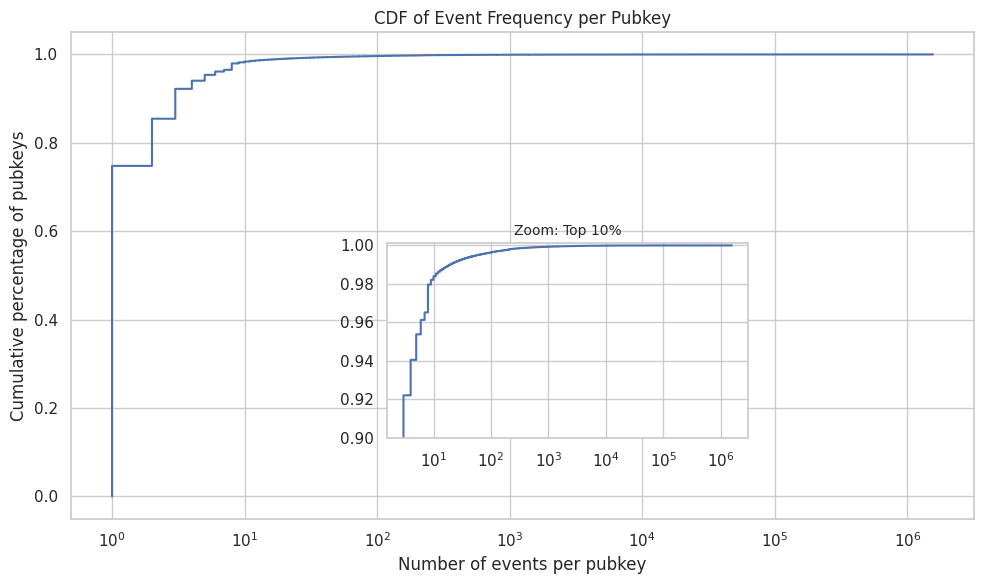

In [14]:
# Step 1: Extract the number of events per pubkey from pubkey_stats
freq = pubkey_stats["event_count"].to_list()
freq_sorted = np.sort(freq)

# Step 2: Compute the cumulative distribution function (CDF)
cdf = np.arange(1, len(freq_sorted) + 1) / len(freq_sorted)

# Step 3: Main plot - CDF of event frequency per pubkey
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(freq_sorted, cdf, where='post', label='CDF of event frequency per pubkey')
ax.set_xlabel('Number of events per pubkey')
ax.set_ylabel('Cumulative percentage of pubkeys')
ax.set_title('CDF of Event Frequency per Pubkey')
ax.set_xscale('log')  # Logarithmic x-axis to better show long tail
ax.grid(True)

# Step 4: Zoom in on the top 10% of the distribution
mask = cdf >= 0.9
freq_zoom = freq_sorted[mask]
cdf_zoom = cdf[mask]

# Step 5: Inset plot - Focus on top 10% of pubkeys
ax_inset = inset_axes(
    ax,
    width="40%",
    height="40%",
    loc='lower center',
    bbox_to_anchor=(0.05, 0.15, 1, 1),
    bbox_transform=ax.transAxes
)
ax_inset.step(freq_zoom, cdf_zoom, where='post')
ax_inset.set_xscale('log')
ax_inset.set_ylim(0.9, 1.001)
ax_inset.set_title('Zoom: Top 10%', fontsize=10)
ax_inset.grid(True)

plt.tight_layout()
plt.show()

In [15]:
# --- Part 1: Pubkeys that appear only once ---

# Filter pubkeys with only one event from pubkey_stats
single_use_pubkeys = pubkey_stats.filter(
    pl.col("event_count") == 1
).select("pubkey")

# Keep only events from those pubkeys
events_single_use = events.join(single_use_pubkeys, on="pubkey", how="inner")

# Group by 'kind' and count events
kind_stats_single_use = (
    events_single_use
    .group_by("kind")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

# Calculate percentage per kind
total_single_use = kind_stats_single_use["count"].sum()
kind_stats_single_use = kind_stats_single_use.with_columns([
    (pl.col("count") / total_single_use * 100).alias("percentage")
])

print("Event kind statistics for pubkeys used only once:")
display(kind_stats_single_use.head(10))


# --- Part 2: Top 1% most active pubkeys ---

# Calculate number of pubkeys in the top 1%
top_1_count = int(0.01 * pubkey_stats.height)

# Get the top 1% by num_events
top_1_percent_pubkeys = (
    pubkey_stats
    .sort("event_count", descending=True)
    .head(top_1_count)
    .select("pubkey")
)

# Keep only events from those pubkeys
events_top_1 = events.join(top_1_percent_pubkeys, on="pubkey", how="inner")

# Group by 'kind' and count events
kind_stats_top_1 = (
    events_top_1
    .group_by("kind")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

# Calculate percentage per kind
total_top_1 = kind_stats_top_1["count"].sum()
kind_stats_top_1 = kind_stats_top_1.with_columns([
    (pl.col("count") / total_top_1 * 100).alias("percentage")
])

print("Event kind statistics for the top 1% most active pubkeys:")
display(kind_stats_top_1.head(10))

Event kind statistics for pubkeys used only once:


kind,count,percentage
i64,u32,f64
3,5424600,36.856409
0,4318903,29.343962
1059,3748147,25.466069
1,691000,4.694868
4,212725,1.445319
10002,143065,0.972028
5,36291,0.246572
5314,36127,0.245458
9041,28134,0.191151


Event kind statistics for the top 1% most active pubkeys:


kind,count,percentage
i64,u32,f64
1,62168269,44.136092
7,32301557,22.93235
4,9089266,6.452885
6,7517214,5.336813
5,5266642,3.73903
9735,4854038,3.446103
1000,4499403,3.194332
42,2567971,1.82312
5300,1279587,0.908437


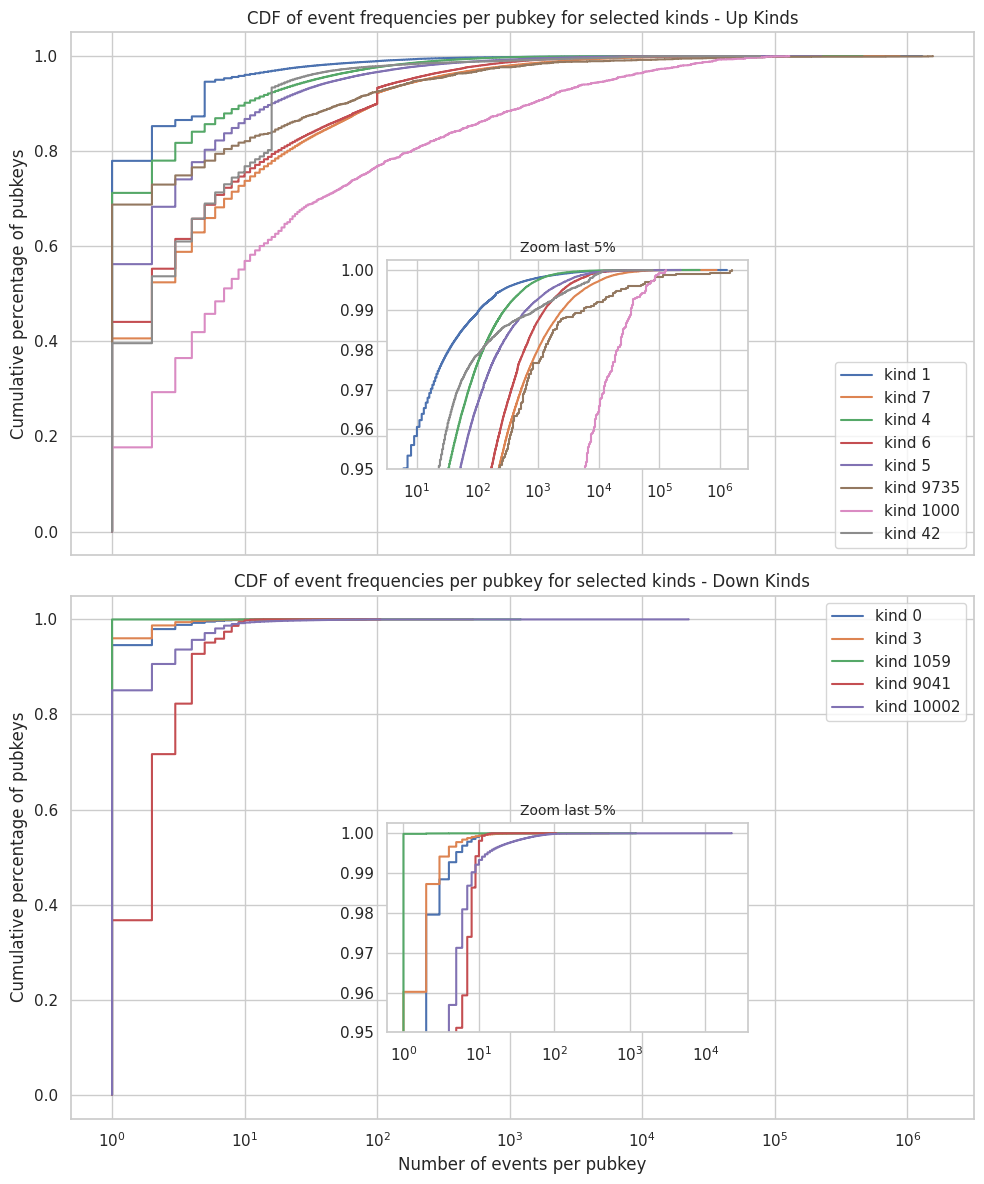

In [16]:
# Filter events by selected kinds from relevant_kinds dataframe
events_filtered = events.filter(pl.col("kind").is_in(relevant_kinds["kind"].to_list()))

# Count number of events per (pubkey, kind) pair
pubkey_kind_counts = (
    events_filtered
    .group_by(["pubkey", "kind"])
    .agg(pl.count().alias("num_events"))
)

# Define 'up_kinds' and 'down_kinds' based on percentage comparisons and threshold
up_kinds = kind_stats.filter(
    (pl.col("perc_event") < pl.col("perc_pubkey")) &
    ((pl.col("perc_event") >= 1) | (pl.col("perc_pubkey") >= 1))
).select("kind").to_series().to_list()

down_kinds = kind_stats.filter(
    (pl.col("perc_event") >= pl.col("perc_pubkey")) &
    ((pl.col("perc_event") >= 1) | (pl.col("perc_pubkey") >= 1))
).select("kind").to_series().to_list()

# Create two vertically stacked subplots with shared x-axis
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

for ax, kinds, title in zip(axes, [up_kinds, down_kinds], ['Up Kinds', 'Down Kinds']):
    # Create inset axis for zoomed-in CDF of last 10%
    ax_inset = inset_axes(
        ax, width="40%", height="40%", loc='lower center',
        bbox_to_anchor=(0.05, 0.15, 1, 1), bbox_transform=ax.transAxes
    )

    for kind in kinds:
        counts = pubkey_kind_counts.filter(pl.col("kind") == kind)["num_events"].to_list()
        if not counts:
            continue

        sorted_counts = np.sort(counts)
        cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)

        # Plot full CDF on main axis
        ax.step(sorted_counts, cdf, where='post', label=f"kind {kind}")

        # Plot zoomed-in CDF (top 5%) on inset axis
        mask = cdf >= 0.95
        ax_inset.step(sorted_counts[mask], cdf[mask], where='post')

    # Main axis formatting
    ax.set_ylabel("Cumulative percentage of pubkeys")
    ax.set_title(f"CDF of event frequencies per pubkey for selected kinds - {title}")
    ax.grid(True)
    ax.legend()

    # Inset axis formatting
    ax_inset.set_xscale('log')
    ax_inset.set_ylim(0.95)
    ax_inset.set_title("Zoom last 5%", fontsize=10)
    ax_inset.grid(True)

# Shared x-axis formatting
axes[-1].set_xlabel("Number of events per pubkey")
axes[-1].set_xscale('log')

plt.tight_layout()
plt.show()

In [17]:
def compute_set_intersections(sets):
    """
    Compute intersections of all combinations of given sets and return a DataFrame
    with counts and percentages relative to the total unique elements across all sets.

    Parameters:
    - sets: dict[str, set]
        A dictionary where keys are set labels and values are sets of pubkeys (or elements).

    Returns:
    - pd.DataFrame with columns:
        'kind_combination' : str (comma-separated combination of set keys)
        'count'            : int (number of elements in the intersection)
        'perc'             : float (percentage of intersection relative to total unique elements)
    """
    all_keys = list(sets.keys())
    # Calculate total number of unique pubkeys across all sets (union)
    total_pubkeys = len(set.union(*sets.values()))

    intersections = {}

    # Iterate over all possible combinations of keys (from size 1 up to all keys)
    for r in range(1, len(all_keys) + 1):
        for combo in combinations(all_keys, r):
            # Compute intersection of sets for current combination of keys
            intersect = set.intersection(*[sets[k] for k in combo])
            count = len(intersect)
            perc = (count / total_pubkeys * 100) if total_pubkeys > 0 else 0
            intersections[combo] = {"count": count, "perc": perc}

    # Convert intersection data into a list of dicts for DataFrame creation
    rows = [
        {
            "kind_combination": ", ".join(combo),
            "count": stats["count"],
            "perc": stats["perc"]
        }
        for combo, stats in intersections.items()
    ]

    # Create DataFrame and sort by count descending
    intersections_df = pd.DataFrame(rows).sort_values(by='count', ascending=False).reset_index(drop=True)

    return intersections_df

Total unique pubkeys: 19681031
Unique pubkeys in kinds 0, 3, 1, 6, 7: 15268930 (77.58%)


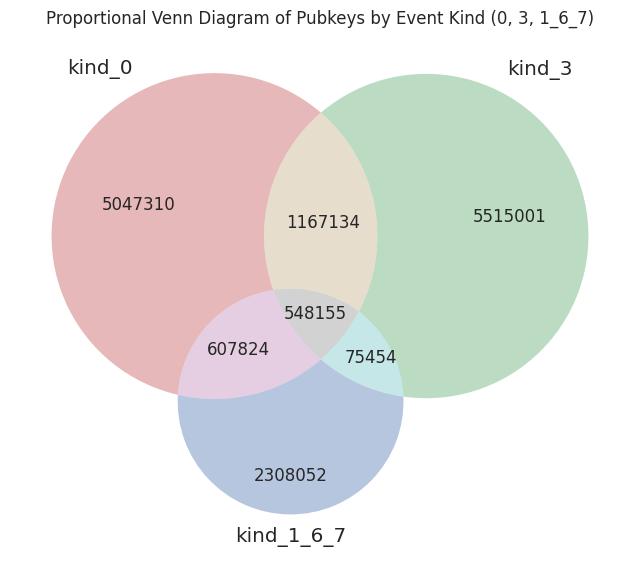

             kind_combination    count       perc
0                      kind_0  7370423  48.270724
1                      kind_3  7305744  47.847125
2                  kind_1_6_7  3539485  23.180963
3              kind_0, kind_3  1715289  11.233852
4          kind_0, kind_1_6_7  1155979   7.570792
5          kind_3, kind_1_6_7   623609   4.084170
6  kind_0, kind_3, kind_1_6_7   548155   3.590003


In [18]:
# --- Step 1: Create sets of pubkeys for each event kind group ---

# Extract unique pubkeys for kind 0 events
kind_0 = set(
    events.filter(pl.col("kind") == 0)
    .select("pubkey")
    .to_series()
    .to_list()
)

# Extract unique pubkeys for kind 3 events
kind_3 = set(
    events.filter(pl.col("kind") == 3)
    .select("pubkey")
    .to_series()
    .to_list()
)

# Extract unique pubkeys for kinds 1, 6, and 7 combined
kind_1_6_7 = set(
    events.filter(pl.col("kind").is_in([1, 6, 7]))
    .select("pubkey")
    .to_series()
    .to_list()
)

# Combine sets into a dictionary for processing and plotting
kind_sets = {
    "kind_0": kind_0,
    "kind_3": kind_3,
    "kind_1_6_7": kind_1_6_7
}

# Calculate total number of unique pubkeys in the entire dataset
all_pubkeys_count = events.select(pl.col("pubkey").n_unique()).to_series().item()

# Calculate unique pubkeys among selected kinds 0, 3, 1, 6, 7
all_kind_pubkeys_count = events.filter(
    pl.col("kind").is_in([0, 3, 1, 6, 7])
).select(pl.col("pubkey").n_unique()).to_series().item()

print(f"Total unique pubkeys: {all_pubkeys_count}")
print(f"Unique pubkeys in kinds 0, 3, 1, 6, 7: {all_kind_pubkeys_count} "
      f"({all_kind_pubkeys_count / all_pubkeys_count * 100:.2f}%)")

# --- Step 2: Plot proportional Venn diagram for the three sets ---

# Since there are 3 sets, use venn3 which supports proportional sizing
plt.figure(figsize=(8, 8))

venn3(subsets=kind_sets.values(), set_labels=kind_sets.keys())

plt.title("Proportional Venn Diagram of Pubkeys by Event Kind (0, 3, 1_6_7)")
plt.show()

# --- Step 3: Compute and display intersections statistics ---

intersections_df = compute_set_intersections(kind_sets)
print(intersections_df)

Total unique pubkeys: 19681031
Unique pubkeys in kinds 1, 6, 7: 3539485 (17.98%)


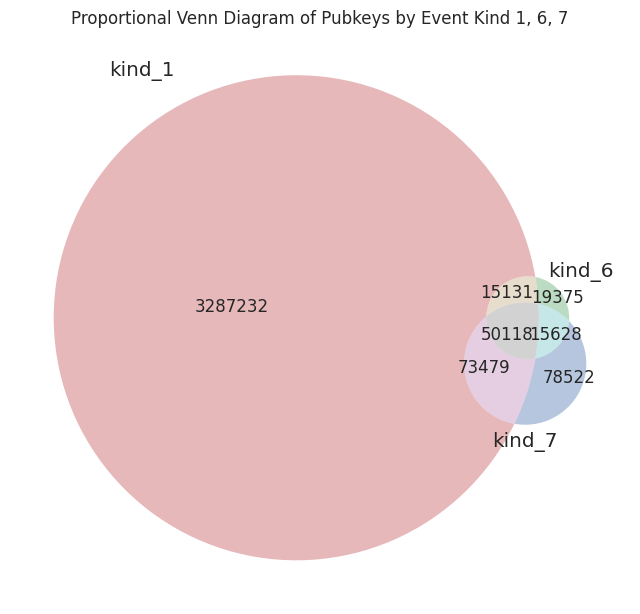

         kind_combination    count       perc
0                  kind_1  3425960  96.792612
1                  kind_7   217747   6.151940
2          kind_1, kind_7   123597   3.491949
3                  kind_6   100252   2.832389
4          kind_6, kind_7    65746   1.857502
5          kind_1, kind_6    65249   1.843460
6  kind_1, kind_6, kind_7    50118   1.415969


In [19]:
# --- Step 1: Create sets of unique pubkeys for kinds 1, 6, and 7 ---

kind_1 = set(events.filter(pl.col("kind") == 1).select("pubkey").to_series().to_list())
kind_6 = set(events.filter(pl.col("kind") == 6).select("pubkey").to_series().to_list())
kind_7 = set(events.filter(pl.col("kind") == 7).select("pubkey").to_series().to_list())

# Dictionary of the pubkey sets by kind
sets = {
    "kind_1": kind_1,
    "kind_6": kind_6,
    "kind_7": kind_7
}

# Total number of unique pubkeys in the entire dataset
all_pubkeys_count = events.select(pl.col("pubkey").n_unique()).to_series().item()

# Number of unique pubkeys involved in kinds 1, 6, and 7 combined
all_kind_pubkeys_count = events.filter(pl.col("kind").is_in([1, 6, 7])) \
    .select(pl.col("pubkey").n_unique()).to_series().item()

print(f"Total unique pubkeys: {all_pubkeys_count}")
print(f"Unique pubkeys in kinds 1, 6, 7: {all_kind_pubkeys_count} "
      f"({all_kind_pubkeys_count / all_pubkeys_count * 100:.2f}%)")

# --- Step 2: Plot a proportional Venn diagram for the three sets ---

plt.figure(figsize=(8, 8))

# venn3 automatically sizes areas proportional to the set sizes and intersections
venn3(subsets=sets.values(), set_labels=sets.keys())

plt.title("Proportional Venn Diagram of Pubkeys by Event Kind 1, 6, 7")
plt.show()

# --- Step 3: Compute and display intersections statistics ---

intersections_df = compute_set_intersections(sets)
print(intersections_df)

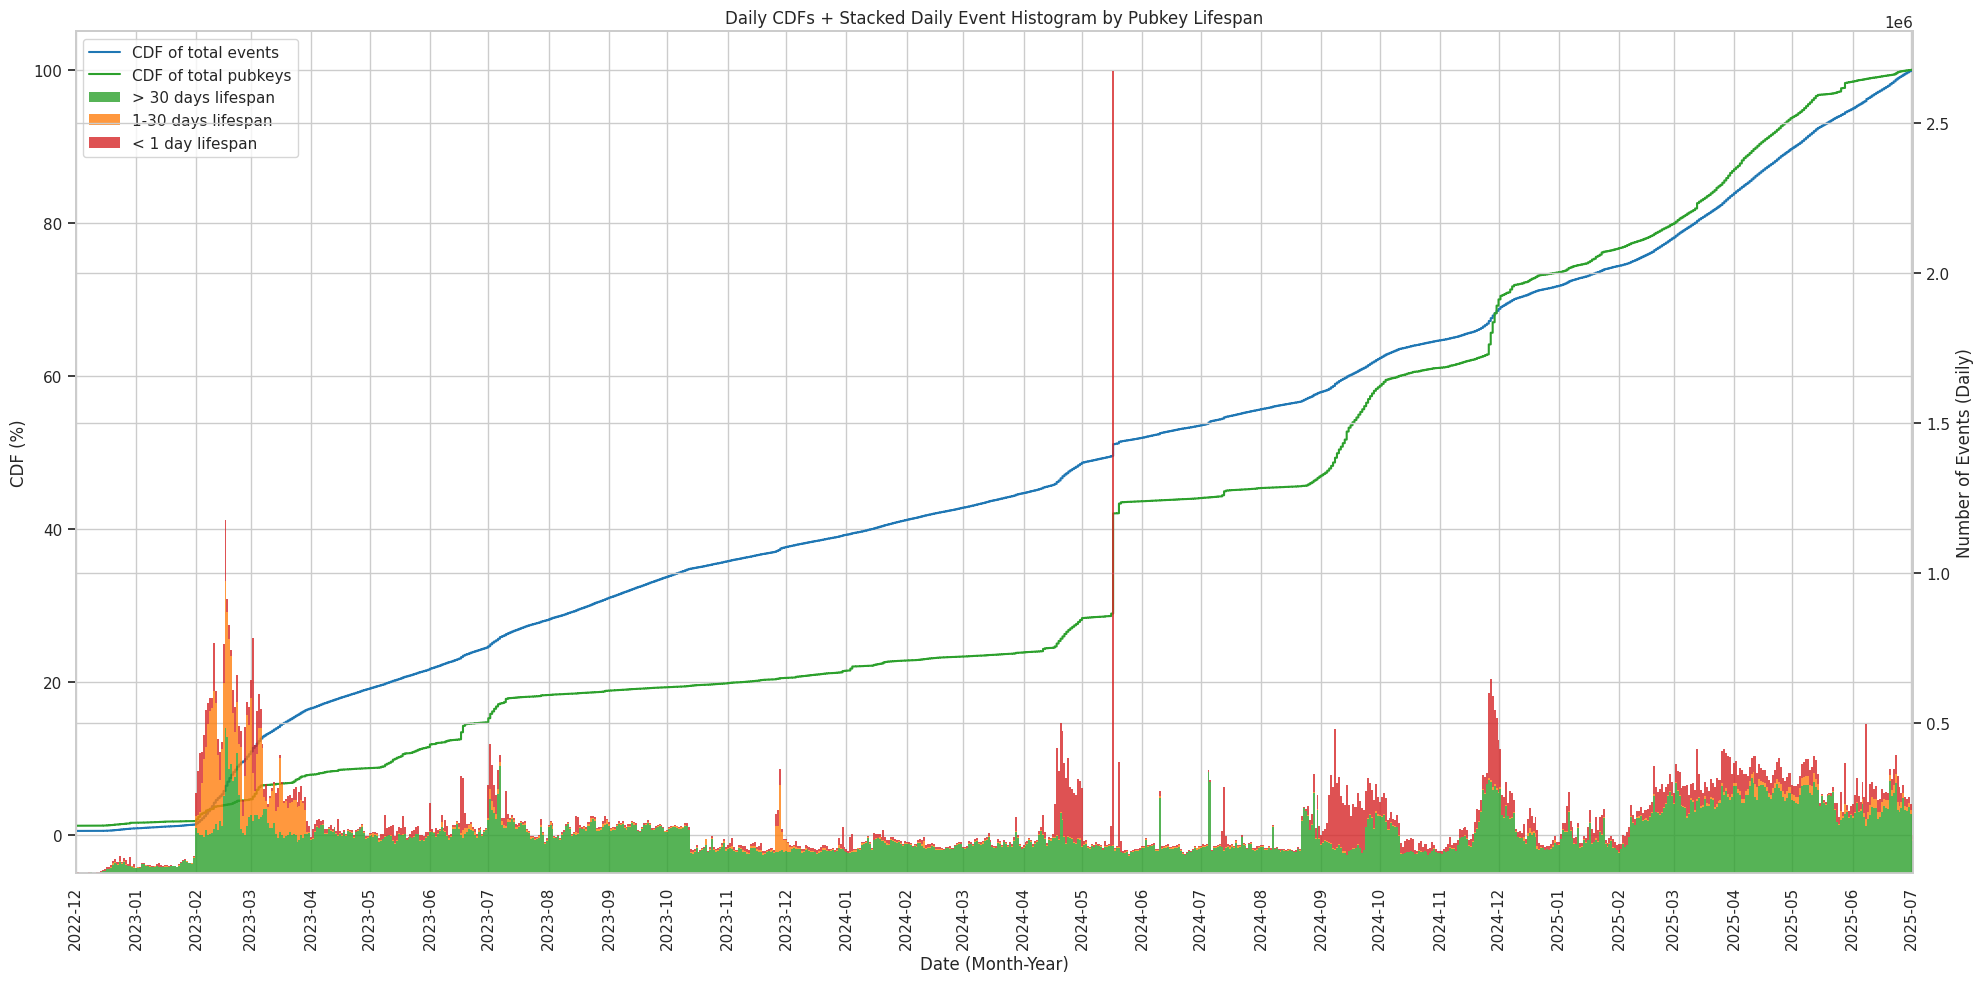

In [20]:
# --- Step 0: Compute CDFs of events and first pubkey appearances ---

# CDF of total events by day
daily = (
    events
    .group_by("day")
    .agg(pl.count().alias("count"))
    .sort("day")
)

total_events = daily["count"].sum()

cdf_df = daily.with_columns([
    pl.col("count").cum_sum().alias("cum_count"),
    (pl.col("count").cum_sum() / total_events * 100).alias("cdf")
])

# CDF of first appearance of each pubkey
first_events = (
    pubkey_stats
    .select([
        pl.col("pubkey"),
        pl.col("first_eventdate")
        .dt.date()
        .alias("first_day")
    ])
)

first_daily = (
    first_events
    .group_by("first_day")
    .agg(pl.count().alias("count"))
    .sort("first_day")
)

total_first = first_daily["count"].sum()

cdf_first_df = first_daily.with_columns([
    pl.col("count").cum_sum().alias("cum_count"),
    (pl.col("count").cum_sum() / total_first * 100).alias("cdf")
])

# --- Step 1: Calculate lifespan per pubkey (days) ---

# Compute lifespan_days by converting lifespan_seconds to days
pubkey_lifespan = pubkey_stats.with_columns([
    (pl.col("lifespan").cast(pl.Int64) / (1000 * 60 * 60 * 24)).alias("lifespan_days")
])
# --- Step 2: Join lifespan info back to events ---

events_lifespan = events.join(pubkey_lifespan.select(["pubkey", "lifespan_days"]), on="pubkey", how="left")

# --- Step 3: Assign lifespan bucket to each event ---

events_lifespan = events_lifespan.with_columns([
    pl.when(pl.col("lifespan_days") < 1)
      .then(pl.lit("less_than_1_day"))
      .when((pl.col("lifespan_days") >= 1) & (pl.col("lifespan_days") <= 30))
      .then(pl.lit("between_1_and_30_days"))
      .otherwise(pl.lit("more_than_30_days"))
      .alias("lifespan_bucket")
])

# --- Step 4: Group by day and lifespan_bucket, count events ---

daily_lifespan_counts = (
    events_lifespan
    .group_by(["day", "lifespan_bucket"])
    .agg(pl.count().alias("count"))
    .sort("day")
)

# --- Step 5: Pivot so each lifespan bucket is a column for plotting stacked bars ---

daily_pivot = daily_lifespan_counts.pivot(
    values="count",
    index="day",
    columns="lifespan_bucket",
    aggregate_function="first"
).fill_null(0).sort("day")

# --- Step 6: Plot stacked bar chart along with CDFs ---

days = pd.to_datetime(cdf_df["day"].to_pandas())
cdf_values = cdf_df["cdf"].to_numpy()

first_days = pd.to_datetime(cdf_first_df["first_day"].to_pandas())
cdf_first_values = cdf_first_df["cdf"].to_numpy()

hist_days = pd.to_datetime(daily_pivot["day"].to_pandas())
counts_less_1 = daily_pivot.get_column("less_than_1_day").to_numpy() if "less_than_1_day" in daily_pivot.columns else np.zeros(len(daily_pivot))
counts_1_to_30 = daily_pivot.get_column("between_1_and_30_days").to_numpy() if "between_1_and_30_days" in daily_pivot.columns else np.zeros(len(daily_pivot))
counts_more_30 = daily_pivot.get_column("more_than_30_days").to_numpy() if "more_than_30_days" in daily_pivot.columns else np.zeros(len(daily_pivot))

fig, ax = plt.subplots(figsize=(20, 10))

# Plot CDFs on primary y-axis
ax.plot(days, cdf_values, drawstyle="steps-post", label="CDF of total events", color="tab:blue")
ax.plot(first_days, cdf_first_values, drawstyle="steps-post", label="CDF of total pubkeys", color="tab:green")

ax.set_xlabel("Date (Month-Year)")
ax.set_ylabel("CDF (%)")
ax.set_xlim(pd.to_datetime("2022-12-01"), max(days.max(), first_days.max()))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.tick_params(axis='x', rotation=90)
ax.grid(True)

# Secondary Y-axis: Stacked bar histogram of daily event counts by lifespan bucket
ax2 = ax.twinx()
ax2.bar(hist_days, counts_more_30, width=1.0, alpha=0.8, color="tab:green", label="> 30 days lifespan", linewidth=0)
ax2.bar(hist_days, counts_1_to_30, bottom=counts_more_30, width=1.0, alpha=0.8, color="tab:orange", label="1-30 days lifespan", linewidth=0)
ax2.bar(hist_days, counts_less_1, bottom=counts_more_30 + counts_1_to_30, width=1.0, alpha=0.8, color="tab:red", label="< 1 day lifespan", linewidth=0)

ax2.set_ylabel("Number of Events (Daily)")

# Combined legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Daily CDFs + Stacked Daily Event Histogram by Pubkey Lifespan")
plt.tight_layout()
plt.show()

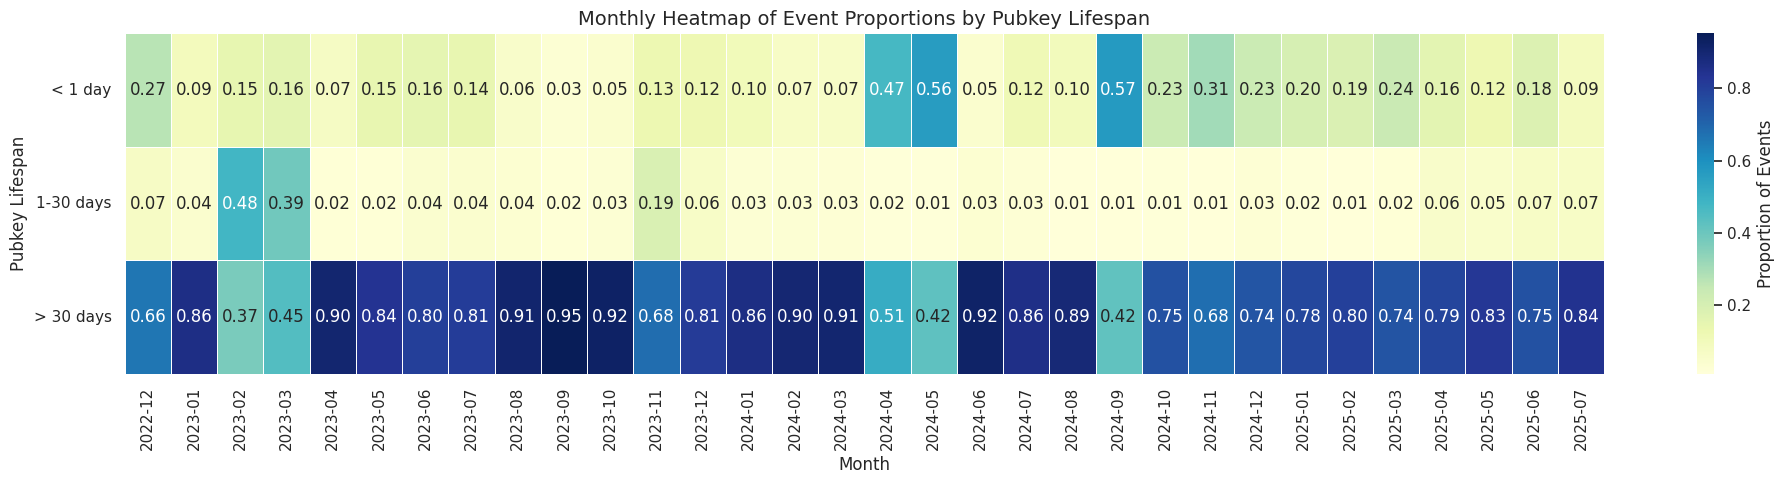

In [21]:
# --- Aggregate by month ---

# Add a 'month' column to the daily table
daily_pivot = daily_pivot.with_columns([
    pl.col("day").cast(pl.Date).dt.truncate("1mo").alias("month")
])

# Group by month and sum the counts
monthly_pivot = (
    daily_pivot
    .group_by("month")
    .agg([
        pl.col("less_than_1_day").sum().alias("less_than_1_day"),
        pl.col("between_1_and_30_days").sum().alias("between_1_and_30_days"),
        pl.col("more_than_30_days").sum().alias("more_than_30_days"),
    ])
    .sort("month")
)

# --- Calculate monthly proportions ---

months = pd.to_datetime(monthly_pivot["month"].to_pandas())
monthly_counts_less_1 = monthly_pivot["less_than_1_day"].to_numpy()
monthly_counts_1_to_30 = monthly_pivot["between_1_and_30_days"].to_numpy()
monthly_counts_more_30 = monthly_pivot["more_than_30_days"].to_numpy()

total_monthly = monthly_counts_less_1 + monthly_counts_1_to_30 + monthly_counts_more_30

# Avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    ratios_less_1 = np.nan_to_num(monthly_counts_less_1 / total_monthly)
    ratios_1_to_30 = np.nan_to_num(monthly_counts_1_to_30 / total_monthly)
    ratios_more_30 = np.nan_to_num(monthly_counts_more_30 / total_monthly)

# --- Create DataFrame for the heatmap ---

heatmap_data = pd.DataFrame({
    "month": months,
    "< 1 day": ratios_less_1,
    "1-30 days": ratios_1_to_30,
    "> 30 days": ratios_more_30,
})

# Set 'month' as index
heatmap_data.set_index("month", inplace=True)

# Filter: include only months from 2022-12 onwards
heatmap_data = heatmap_data[heatmap_data.index >= pd.to_datetime("2022-12-01")]

# Transpose to have categories as rows
heatmap_data = heatmap_data.T

# --- Plot heatmap ---

fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="white",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Proportion of Events'},
    ax=ax
)

ax.set_title("Monthly Heatmap of Event Proportions by Pubkey Lifespan", fontsize=14)
ax.set_xlabel("Month")
ax.set_ylabel("Pubkey Lifespan")

# --- Center x-tick labels under each heatmap cell ---
xticks = np.arange(len(heatmap_data.columns)) + 0.5  # centers on cells
xtick_labels = [dt.strftime("%Y-%m") for dt in heatmap_data.columns]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=90, ha="center")

plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

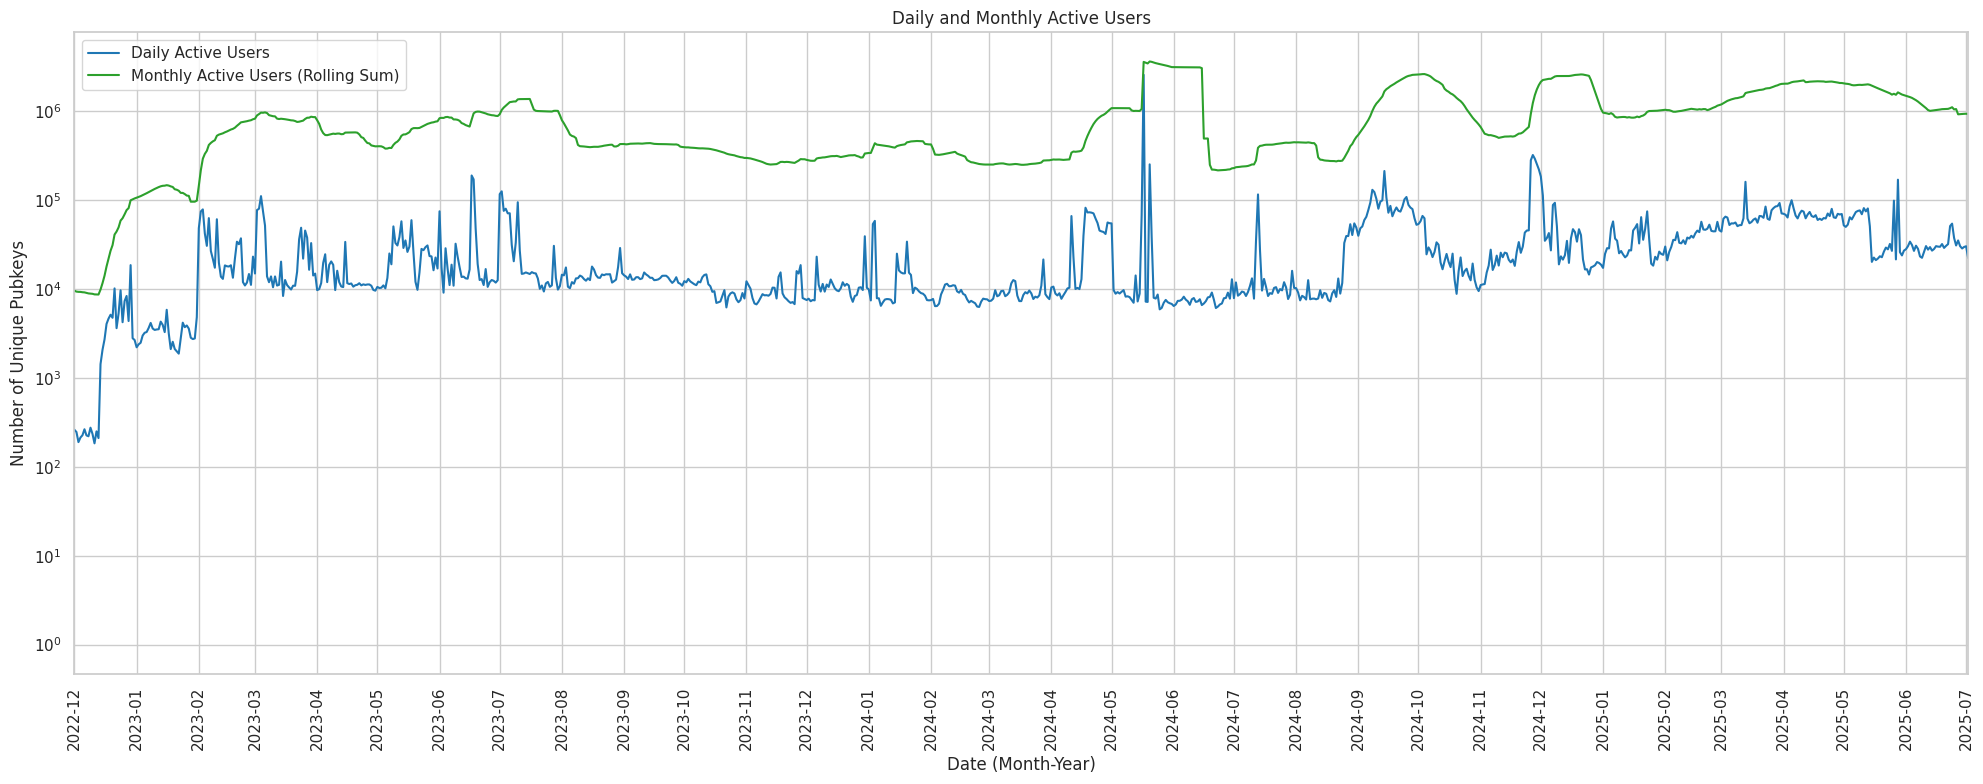

In [22]:
# --- Compute DAU ---
dau = (
    events
    .group_by("day")
    .agg(pl.col("pubkey").n_unique().alias("DAU"))
    .sort("day")
)

# Convert to pandas for rolling
dau_pd = dau.to_pandas()
dau_pd["day"] = pd.to_datetime(dau_pd["day"])
dau_pd.set_index("day", inplace=True)

# --- Compute MAU using rolling window ---
dau_pd["MAU"] = dau_pd["DAU"].rolling("30D").sum()  # Overestimate, but close for simplicity

# Plot
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(dau_pd.index, dau_pd["DAU"], label="Daily Active Users", color="tab:blue")
ax.plot(dau_pd.index, dau_pd["MAU"], label="Monthly Active Users (Rolling Sum)", color="tab:green")

ax.set_title("Daily and Monthly Active Users")
ax.set_xlabel("Date (Month-Year)")
ax.set_ylabel("Number of Unique Pubkeys")
ax.set_xlim(pd.to_datetime("2022-12-01"), dau_pd.index.max())
ax.set_yscale('log')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.tick_params(axis='x', rotation=90)
ax.grid(True)
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

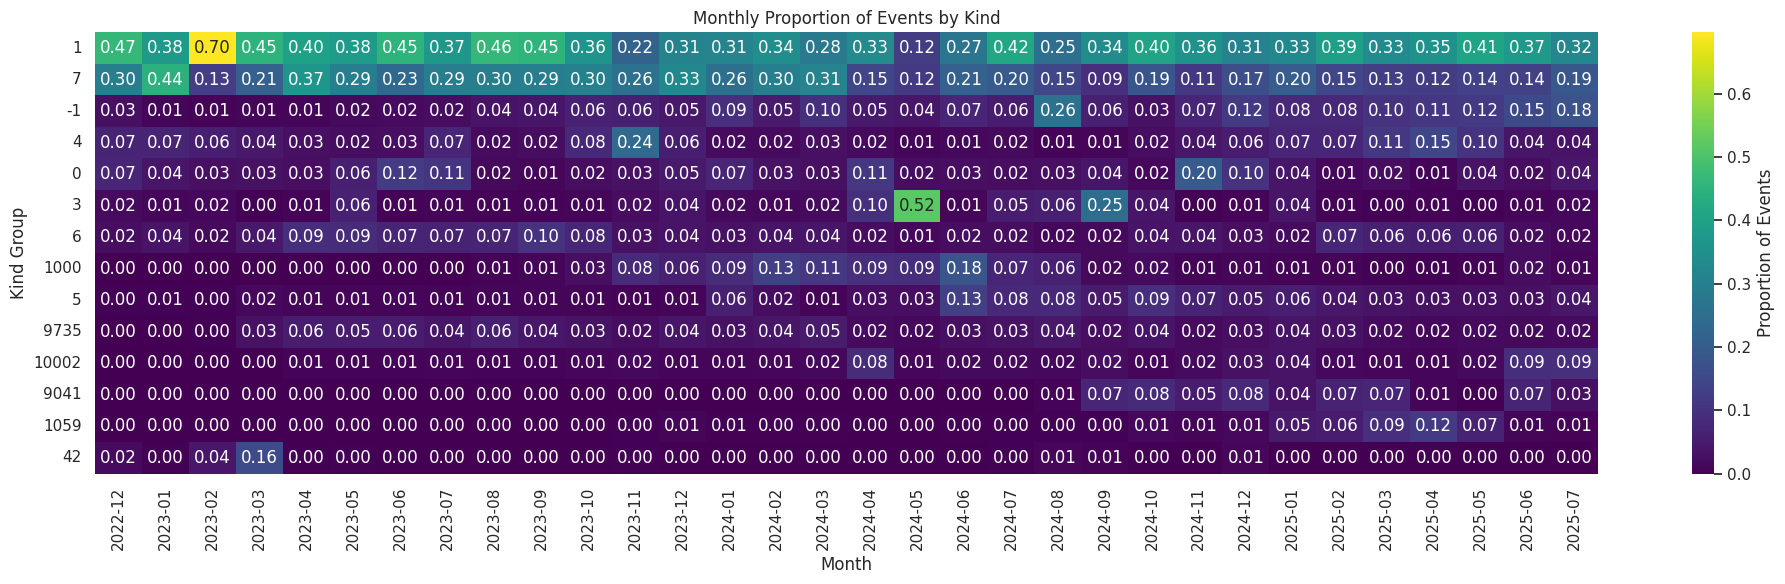

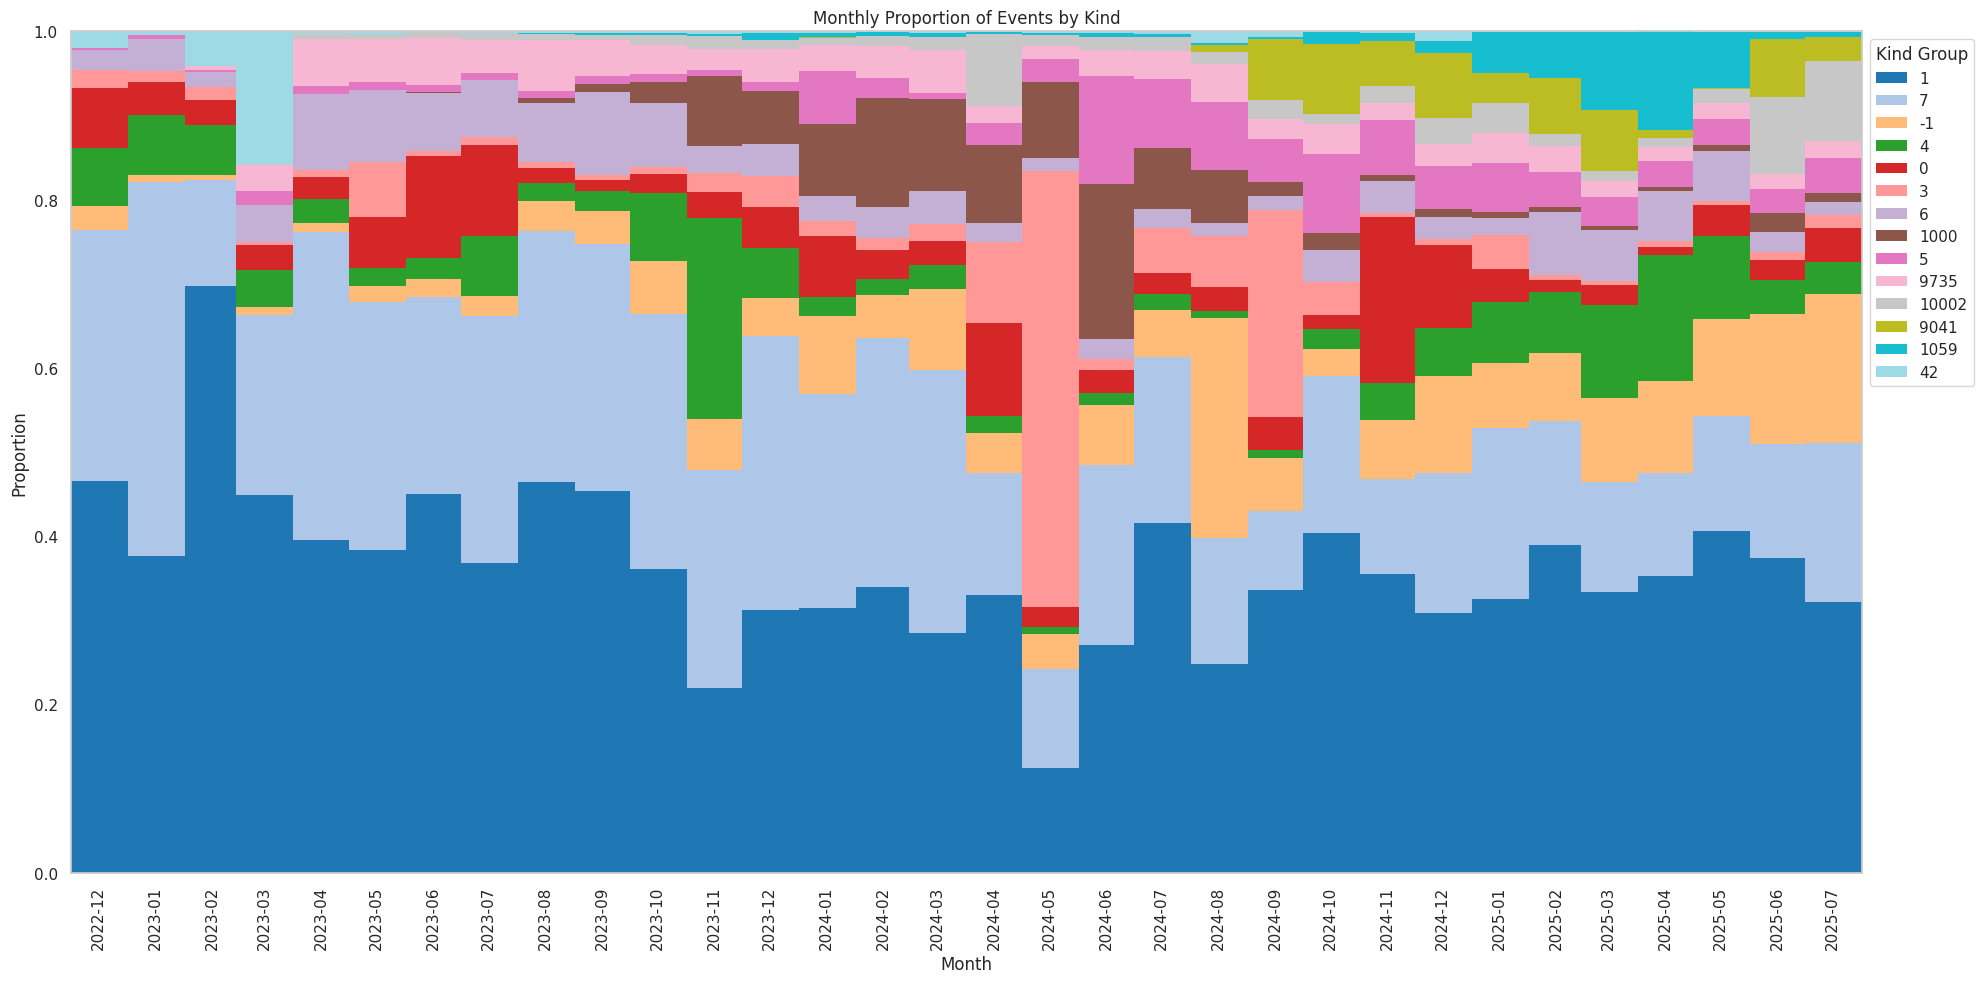

In [23]:
# Define the subset of kinds to keep
subset_kinds = kind_stats.filter(
    (pl.col("perc_event") >= 1) | (pl.col("perc_pubkey") >= 1)
)["kind"].to_list()

# Create new column 'kind_group': keep kind if in subset, else -1
events_grouped = events.with_columns([
    pl.when(pl.col("kind").is_in(subset_kinds))
      .then(pl.col("kind"))
      .otherwise(-1)
      .alias("kind_group")
])

# Count events by month and kind_group
counts = (
    events_grouped
    .group_by(["month", "kind_group"])
    .agg(pl.count().alias("count"))
    .sort(["month", "kind_group"])
)

# Count total events per month
totals = counts.group_by("month").agg(pl.col("count").sum().alias("total_count"))

# Join and calculate proportions
joined = counts.join(totals, on="month").with_columns(
    (pl.col("count") / pl.col("total_count")).alias("proportion")
)

# Pivot: kind_group as rows, months as columns
pivot = joined.pivot(
    values="proportion",
    index="kind_group",
    columns="month"
).fill_null(0).sort("kind_group")

# Filter months from 2022-12-01 onwards
start_date = pd.Timestamp("2022-12-01")
months = [col for col in pivot.columns if col != "kind_group"]
months_pd = [pd.to_datetime(str(m)) for m in months]
filtered_cols = ["kind_group"] + [m for m, m_pd in zip(months, months_pd) if m_pd >= start_date]

pivot = pivot.select(filtered_cols)

# Convert to pandas for plotting
df_heatmap = pivot.to_pandas().set_index("kind_group")

# Format month columns to YYYY-MM for nicer x-axis labels
df_heatmap.columns = [pd.to_datetime(c).strftime("%Y-%m") for c in df_heatmap.columns]

# Sort rows by total sum descending
df_heatmap = df_heatmap.loc[df_heatmap.sum(axis=1).sort_values(ascending=False).index]

# Plot heatmap
plt.figure(figsize=(20, 6))
ax = sns.heatmap(
    df_heatmap,
    linewidths=0,
    linecolor="white",
    cmap="viridis",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Proportion of Events"}
)

ax.set_title("Monthly Proportion of Events by Kind")
ax.set_xlabel("Month")
ax.set_ylabel("Kind Group")

plt.xticks(rotation=90, ha="center")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Convert to pandas
df_area = pivot.to_pandas().set_index("kind_group")

# Sort rows (kind_group) by total share descending
df_area = df_area.loc[df_area.sum(axis=1).sort_values(ascending=False).index]

# Extract months from columns as datetime
months_str = df_area.columns.tolist()
months_dt = [pd.to_datetime(m) for m in months_str]
months_dt_sorted = sorted(months_dt)

# Shift tick positions to the center of the step (middle of each month span)
months_dt_shifted = [m + pd.Timedelta(days=15) for m in months_dt_sorted]

# Extend months for step='post'
months_extended = months_dt_sorted + [months_dt_sorted[-1] + relativedelta(months=1)]

# Extract kind_group values
kind_groups = df_area.index.tolist()

# Prepare data matrix
stack_data = df_area[months_str].values
last_col = stack_data[:, -1][:, np.newaxis]
stack_data_extended = np.hstack([stack_data, last_col])

# Colors
num_kinds = len(kind_groups)
cmap = cm.get_cmap("tab20", num_kinds)
colors = [cmap(i) for i in range(num_kinds)]

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
ax.stackplot(
    months_extended,
    stack_data_extended,
    labels=[str(k) for k in kind_groups],
    colors=colors,
    step='post',
    linewidths=0
)

# Labels and axes
ax.set_ylabel("Proportion")
ax.set_title("Monthly Proportion of Events by Kind")
ax.set_xlim([months_extended[0], months_extended[-1]])
ax.set_ylim(0, 1)
ax.set_xlabel("Month")

# Center ticks between steps
ax.set_xticks(months_dt_shifted)
ax.set_xticklabels([d.strftime("%Y-%m") for d in months_dt_sorted], rotation=90, ha="center")

# Legend
ax.legend(title="Kind Group", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.grid(True)
plt.show()

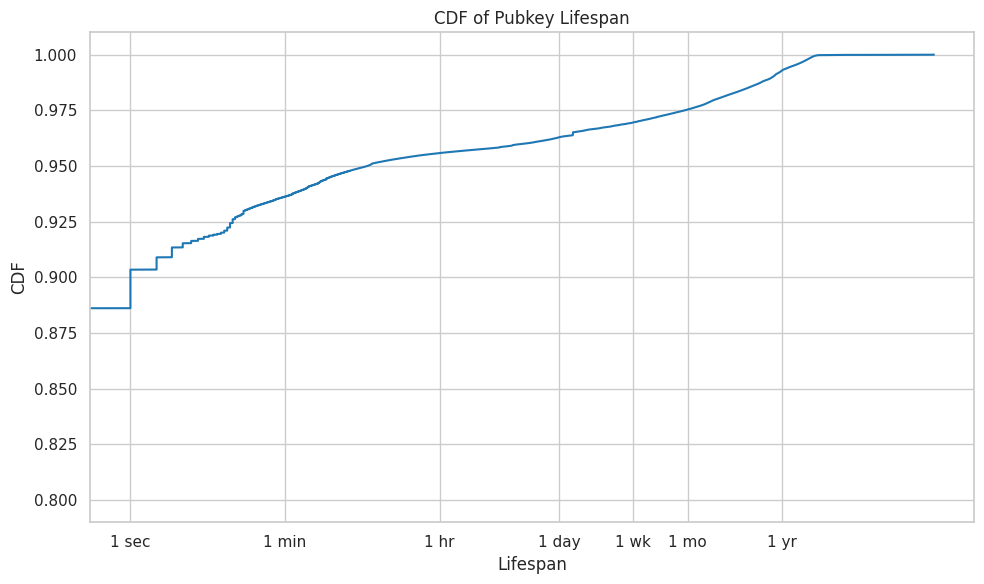

In [24]:
lifespan_data = pubkey_stats.with_columns([
    (pl.col("lifespan").cast(pl.Float64) / 1000).alias("lifespan_scaled")
])

lifespan_sorted = np.sort(lifespan_data["lifespan_scaled"].to_numpy())
cdf = np.arange(1, len(lifespan_sorted) + 1) / len(lifespan_sorted)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lifespan_sorted, cdf, label="CDF", color="tab:blue")
ax.set_xscale("log")

ticks_values = [1, 60, 3600, 86400, 604800, 2592000, 31536000]
ticks_labels = ["1 sec", "1 min", "1 hr", "1 day", "1 wk", "1 mo", "1 yr"]

ax.set_xticks(ticks_values)
ax.set_xticklabels(ticks_labels)

ax.set_xlabel("Lifespan")
ax.set_ylabel("CDF")
ax.set_title("CDF of Pubkey Lifespan")
ax.grid(True)
ax.set_ylim(0.79, 1.01)

plt.tight_layout()
plt.show()

In [25]:
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Filtro per chiavi con più di 2 eventi e primo evento dopo il 2022-12-01
df = pubkey_stats.filter(
    (pl.col("event_count") > 2) &
    (pl.col("first_eventdate") > pl.datetime(2022, 12, 1))
)

# Aggiungi colonne timestamp in secondi (Int64)
df = df.with_columns([
    (pl.col("first_eventdate").cast(pl.Int64) // 1_000).alias("first_eventdate_sec"),
    (pl.col("last_eventdate").cast(pl.Int64) // 1_000).alias("last_eventdate_sec"),
])

# Converte le colonne duration in secondi (Int64)
for col in ["lifespan", "mean_interval", "median_interval", "std_interval"]:
    df = df.with_columns(
        (pl.col(col).cast(pl.Int64) // 1_000).alias(f"{col}_sec")
    )

# Seleziona solo le feature per il clustering
features = df.select([
    "event_count",
    "first_eventdate_sec",
    "last_eventdate_sec",
    "lifespan_sec",
    "mean_interval_sec",
    "median_interval_sec",
    "std_interval_sec"
]).to_pandas()

# Normalizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Clustering con KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Aggiungi cluster al DataFrame Polars
df = df.with_columns(pl.Series(name="cluster", values=labels))

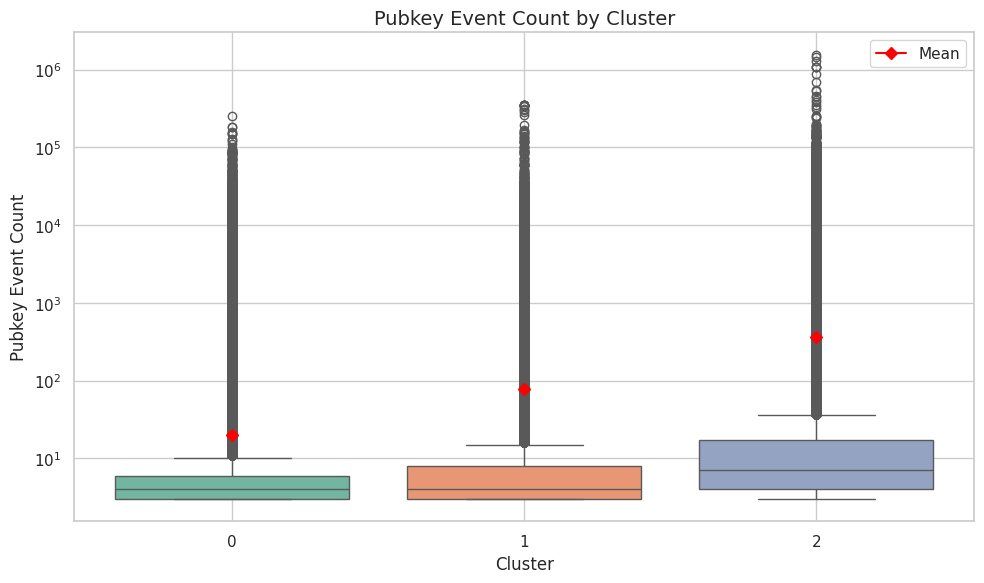

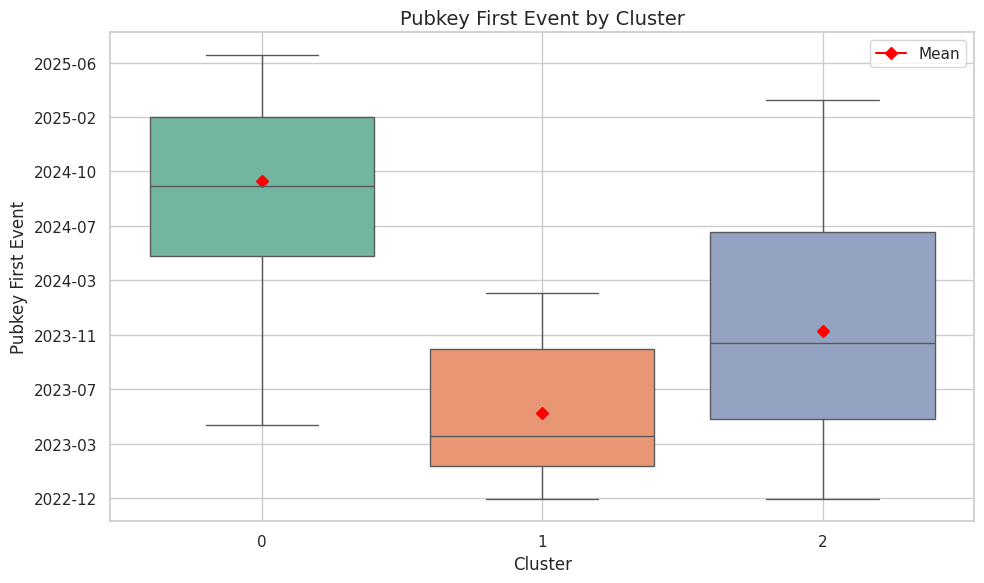

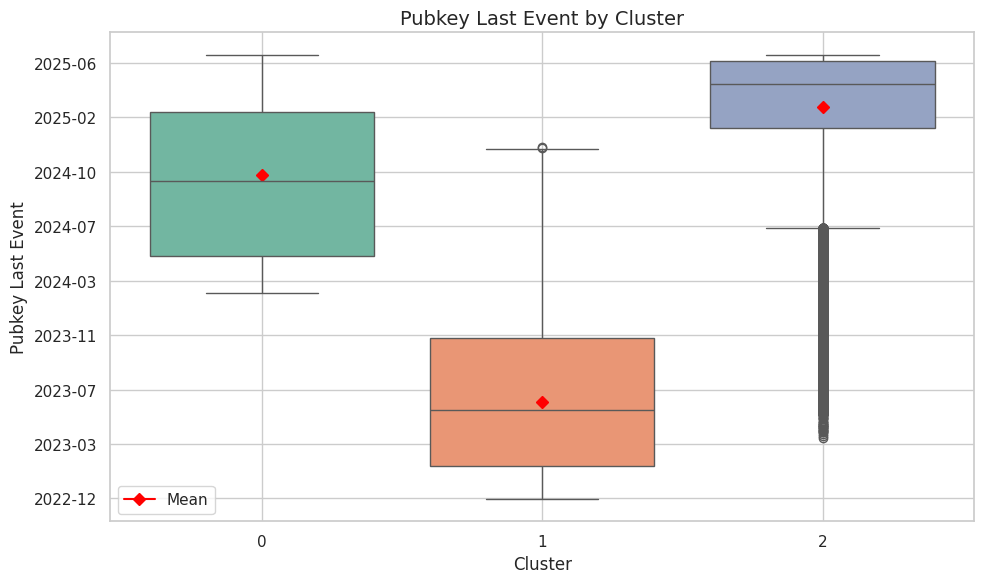

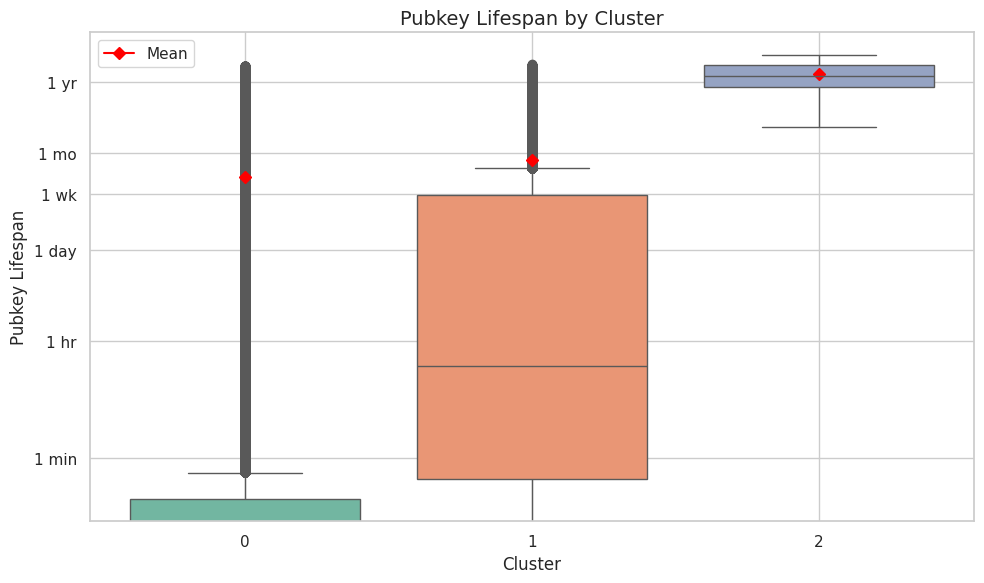

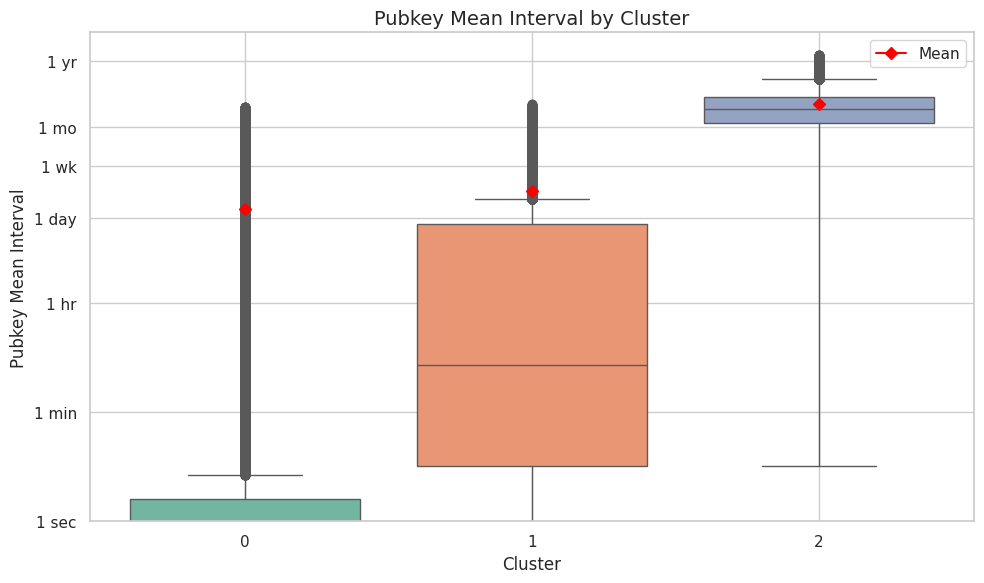

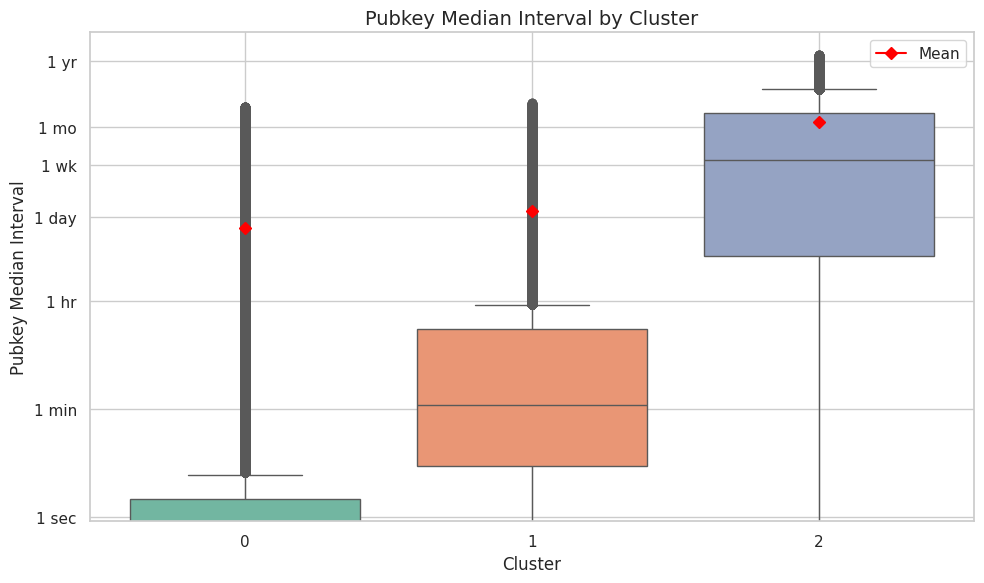

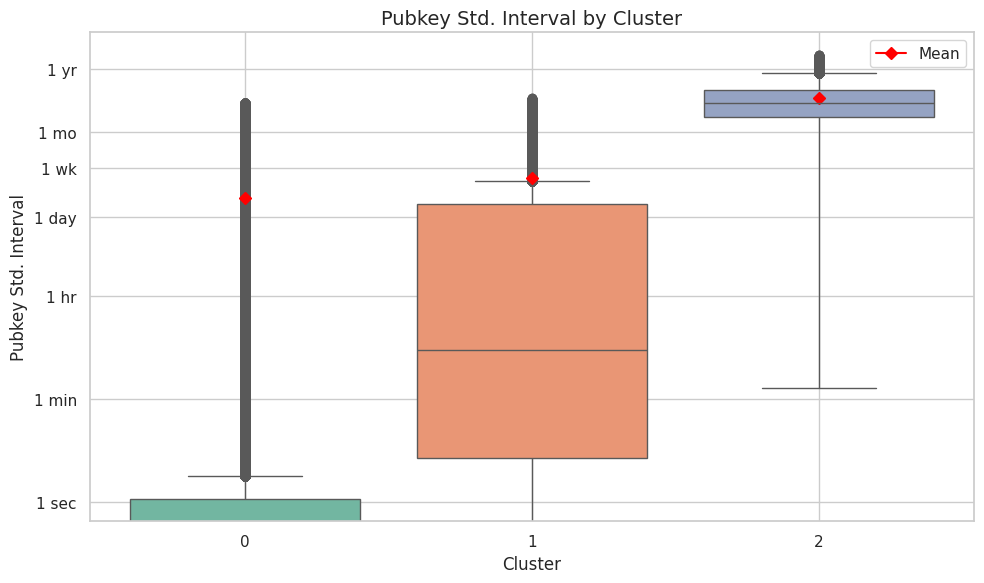

In [26]:
# Convert to pandas
df_pd = df.to_pandas()

# Readable mapping: feature → (label, column, type)
feature_info = {
    "event_count": ("Pubkey Event Count", "event_count", "numeric"),
    "first_eventdate": ("Pubkey First Event", "first_eventdate", "datetime"),
    "last_eventdate": ("Pubkey Last Event", "last_eventdate", "datetime"),
    "lifespan": ("Pubkey Lifespan", "lifespan", "duration"),
    "mean_interval": ("Pubkey Mean Interval", "mean_interval", "duration"),
    "median_interval": ("Pubkey Median Interval", "median_interval", "duration"),
    "std_interval": ("Pubkey Std. Interval", "std_interval", "duration"),
}

# Palette for clusters
palette = sns.color_palette("Set2", n_colors=df_pd["cluster"].nunique())

# Fixed ticks in seconds and their corresponding labels for duration axis
fixed_ticks = [
    1,          # 1 second
    60,         # 1 minute
    3600,       # 1 hour
    86400,      # 1 day
    604800,     # 1 week
    2592000,    # 1 month (approx. 30 days)
    31536000,   # 1 year
]
fixed_labels = ["1 sec", "1 min", "1 hr", "1 day", "1 wk", "1 mo", "1 yr"]

def fixed_duration_formatter(x, pos):
    # Return label only if x matches a fixed tick, else empty string
    if x in fixed_ticks:
        idx = fixed_ticks.index(x)
        return fixed_labels[idx]
    else:
        return ""

# Pre-conversion: datetime and duration → seconds as float
for key, (_, col, kind) in feature_info.items():
    if kind == "datetime":
        df_pd[col + "_sec"] = df_pd[col].astype("int64") // 1_000
    elif kind == "duration":
        df_pd[col + "_sec"] = df_pd[col].dt.total_seconds()

# Plotting
for key, (label, col, kind) in feature_info.items():
    plot_col = col + "_sec" if kind in {"datetime", "duration"} else col

    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        x="cluster",
        y=plot_col,
        data=df_pd,
        palette=palette,
        showfliers=True,
        linewidth=1
    )

    # Overlay mean (red diamond) and median (blue circle)
    means = df_pd.groupby("cluster")[plot_col].mean()

    for i in range(len(means)):
        ax.plot(i, means[i], marker='D', color='red', markersize=6, label='Mean' if i == 0 else "")

    plt.title(f"{label} by Cluster", fontsize=14)
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel(label, fontsize=12)

    # Custom y-axis formatting
    if kind == "duration":
        ax.set_yscale("log")
        ax.yaxis.set_major_locator(mticker.FixedLocator(fixed_ticks))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(fixed_duration_formatter))
    elif kind == "numeric":
        ax.set_yscale("log")
    elif kind == "datetime":
        ax.yaxis.set_major_formatter(
            plt.FuncFormatter(lambda x, _: datetime.datetime.fromtimestamp(x).strftime("%Y-%m"))
        )

    plt.grid(True)
    if 'Mean' in ax.get_legend_handles_labels()[1]:
        plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
bigbrotr.close()